## Sinewave Function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MCMC_DZ.MCMC.Statistic_tools as Sts
import MCMC_DZ.MCMC.Visualization_tools as Vts
from MCMC_DZ.MCMC.MetropolisHastingMCMC.MHMC import MHMC
import MCMC_DZ.MCMC.MetropolisHastingMCMC.ProposalDistributions as PDs
from MCMC_DZ.BayesianInference.Likelihood_functions import Sinewave

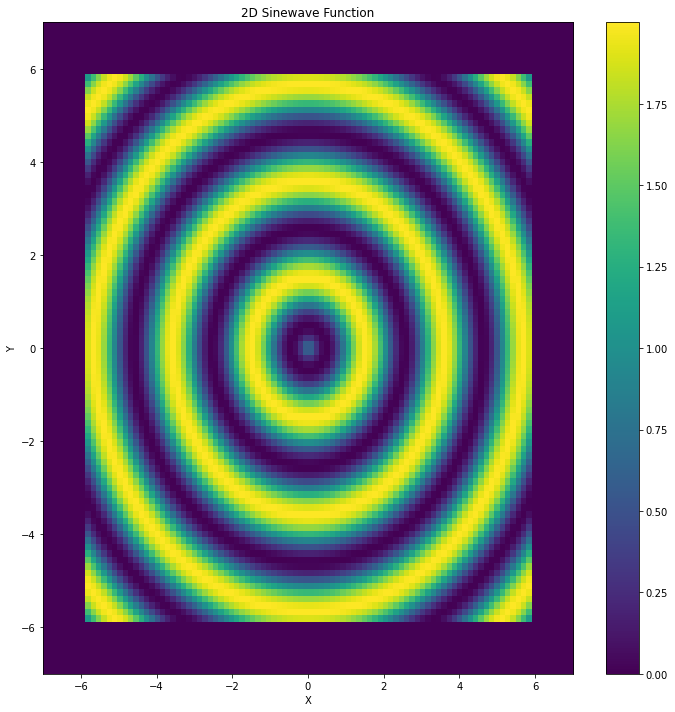

In [6]:
Data_range = np.array([[-6, 6], [-6, 6]])
SF = Sinewave.Sinewave_function([3, 1], Data_range)
Vts.Target_Distribution_Visualization(X_range=[-7, 7], Y_range=[-7, 7], Tar_Dis=SF.f, Func_name="2D Sinewave Function", alpha=1)

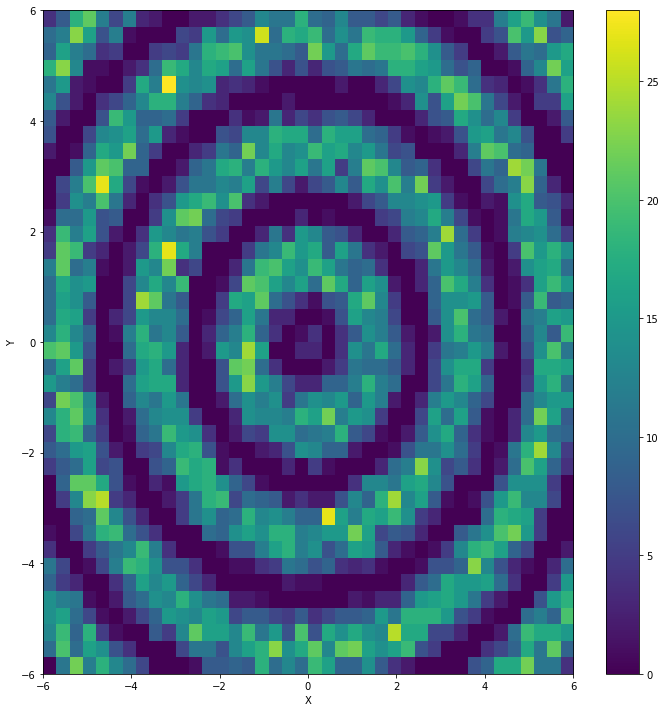

In [7]:
Data_range = np.array([[-6, 6], [-6, 6]])

SFFD_P = Sts.FakeDataGen2D_Poisson(SF.f, [[-6, 6], [-6, 6]], 40, scaler=100)

Vts.PlotHeatmap(SFFD_P.x ,SFFD_P.y, SFFD_P.BinsValue.reshape(SFFD_P.x.shape), xlabel="X", ylabel="Y", zlabel="F(X,Y)")

In [8]:
def Prior(params):
    if (0<params[0] and params[0]<20 and 0<=params[1] and params[1]<3):
        return 1
    else:
        return 0
SF_l = Sts.LikeliFuncGen(SFFD_P, SF, Prior)

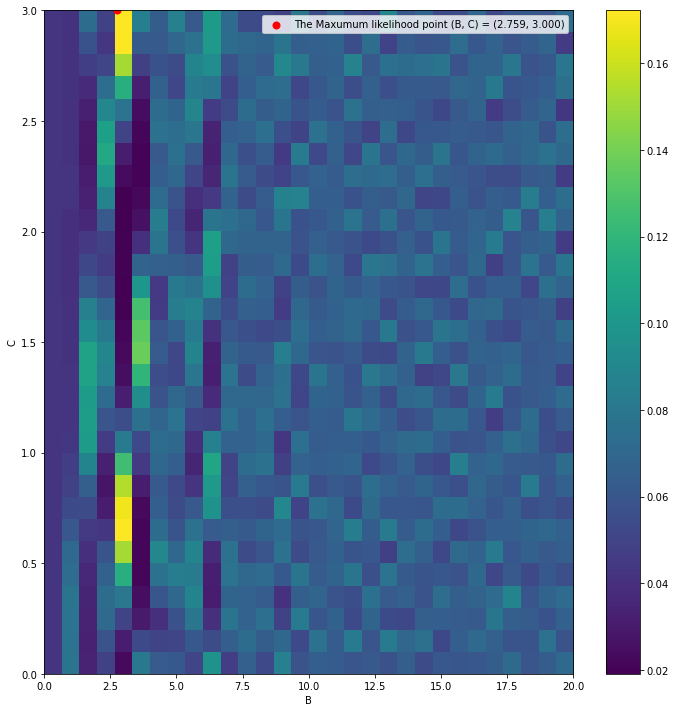

In [10]:
Bs = np.linspace(0, 20, 30)
Cs = np.linspace(0, 3, 30)
Bs, Cs = np.meshgrid(Bs, Cs)

Ls = []
for params in zip(Bs.flatten(), Cs.flatten()):
    Ls.append(SF_l.Likelihood(params))

Ls = np.asarray(Ls).reshape(Bs.shape)
Vts.PlotHeatmap(Bs, Cs, Ls, xlabel="B", ylabel="C", zlabel="l(A, B)", Plot_Max=True)

In [11]:
def Normal(thetas):
    Mu = [10,10]
    Sigma = np.asanyarray([[1,0],[0,1]])
    return np.exp(-0.5*(thetas-Mu)@(thetas-Mu))

In [22]:
Res = []
SDs = []

In [49]:
sd = [7, 2]
SDs.append(sd)
steps = 1000000
Prop_G = PDs.GaussianProposalDistribution(sd=sd, Dim=2)
MHMC_SF = MHMC(rho=SF_l.Posterior, log_likelihood=False)
Res_G_SF = MHMC_SF.generate(
    theta0=[0 for _ in range(2)], 
    qProb=Prop_G.qProb,
    qSamp=Prop_G.qSample,
    steps=steps,
    OutputRunTime=100,
    MaxTime=600
)
Res.append(Res_G_SF)

In [50]:
for Res_G_SF, sd in zip(Res, SDs):
    print(Res_G_SF["Run_Times"][-1])

599.830917861
599.877960236


In [51]:
# for Res_G_SF, sd in zip(Res, SDs):
#     Vts.density_plot(
#         Res_G_SF["Thetas"], 
#         bins=30,
#         burn_in=100,
#         credible_region=0,
#         x_name="B",
#         y_name="C",
#         label = f" with Standard Deviance = {sd}",
#         alpha=1
#     )

In [68]:
k = 0

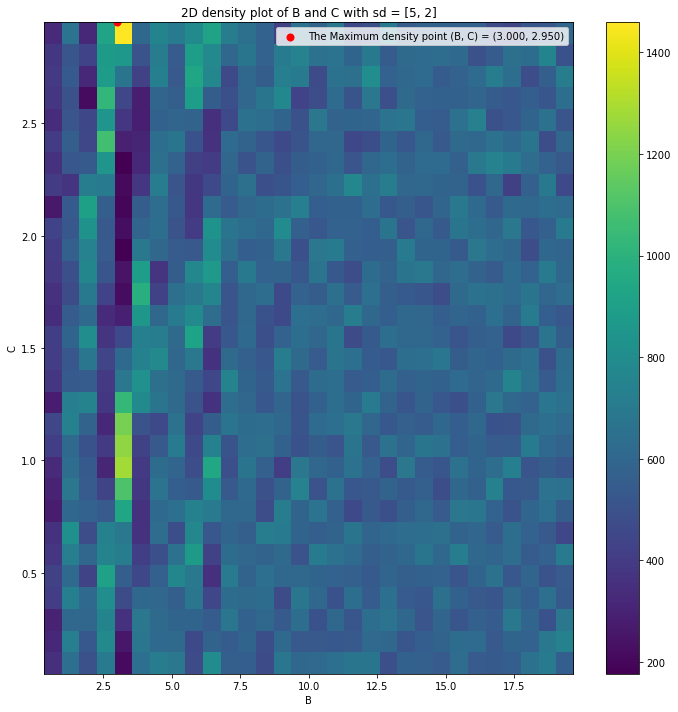

In [69]:
Res_G_SF = Res[k]
sd = SDs[k]

Vts.density_plot(
    Res_G_SF["Thetas"], 
    bins=30,
    burn_in=100,
    credible_region=0,
    x_name="B",
    y_name="C",
    label = f" with sd = {sd}",
    alpha=1
)

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

def density_plots(Thetas, plot_axis, bins, burn_in, axis_name=[], cr_1D=0, cr_2D=0, figsize=(10, 9), cmap='viridis', information=""):
    """
    Plot the density of each axis and the heat map of each pair of axis    

    Arguments
    ---------
    Thetas (np.array): the value of parameters generated by the MCMC model
    plot_axis (List[int]): the axis plotted by the function
    bins (int): the number of bins of each histogram and heat map
    burn_in (int): the number of the data points want to "burn_in" for the graph
    cr_1D (float): the credible region of each 1D density histogram
    figsize: the figure size of the plots
    cmap: the color map used for the 2D histogram
    information (str): information to be displayed on the right corner of the plot

    Returns
    -------
    None
    """

    if not(plot_axis):
        plot_axis = [i for i in range(Thetas.shape[1])]
    n_axis = len(plot_axis)
    datasize = Thetas.shape[0]
    CR_1D = {}

    with plt.style.context("ggplot"):

        fig, axes = plt.subplots(ncols=n_axis, nrows=n_axis, figsize=figsize)
        for i in range(0,n_axis):
            for j in range(0, i+1):
                if i==j:
                    cs, bs, patches = axes[i, j].hist(Thetas[burn_in:, plot_axis[i]], bins=bins, color="steelblue")
                    if axis_name:
                        axes[i, j].set_xlabel(axis_name[i])
                    else:
                        axes[i, j].set_xlabel(f"$x_{plot_axis[i]}$")
                    axes[i, j].set_ylabel("Counts")
                    if (cr_1D):
                        CR_1D[i] = []
                        posterior_prob = 0
                        posts = cs/(datasize-burn_in)

                        while(posterior_prob<cr_1D):
                            max_pos_idx = np.argmax(posts)
                            posterior_prob += posts[max_pos_idx]
                            posts[max_pos_idx] = -1
                            CR_1D[i].append(bs[max_pos_idx:max_pos_idx+2])
                            patches[max_pos_idx].set_facecolor("#ec2d01")

                else:
                    # Create the heatmap using hist2d
                    counts, x_edges, y_edges = np.histogram2d(Thetas[burn_in:, plot_axis[j]], Thetas[burn_in:, plot_axis[i]], bins=bins)
                    if (cr_2D):
                        threshold = np.percentile(counts, (1-cr_2D) * 100)
                        # Create a custom colormap with orange for the credible region and use it for the heatmap
                        cmap_custom = plt.get_cmap(cmap)
                        cmap_custom = ListedColormap(cmap_custom.colors)
                        cmap_custom.set_over("#ec2d01")
                        heatmap = axes[i, j].imshow(counts.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap=cmap_custom, origin='lower', aspect='auto', vmax=threshold)
                    else:
                        # Plot the heatmap without the credible region
                        heatmap = axes[i, j].imshow(counts.T, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap=cmap, origin='lower', aspect='auto')

                    if axis_name:
                        axes[i, j].set_xlabel(axis_name[j])
                        axes[i, j].set_ylabel(axis_name[i])
                    else:
                        axes[i, j].set_xlabel(f"$x_{plot_axis[j]}$")
                        axes[i, j].set_ylabel(f"$x_{plot_axis[i]}$")
                    fig.delaxes(axes[j, i])

        # Add colorbar to the whole plot
        cbar_ax = fig.add_axes([0.95, (1/n_axis)*1.08, 0.02, 1-(1/n_axis)*1.18]) # left, bottom, width, height
        fig.colorbar(heatmap, cax=cbar_ax)

        N = "NULL"
        fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.3)
        legend_text = f"Credible Region(1D) = {cr_1D if cr_1D else N}, Credible Region(2D) = {cr_2D if cr_2D else N}"
        fig.legend(fontsize=10, handles=[Rectangle((0,0),1,1,color="#ec2d01")], labels=[legend_text], loc="upper right", bbox_to_anchor=(1.0, 1.0))  # Adjust the position of the legend to the right upper corner

        # Add the information board on the right-hand corner of the plot, aligned with the legend
        info_ax = fig.add_axes([(1-1/n_axis) * 1.15, 0.87, 0.15, 0.1], frame_on=False)  # left, bottom, width, height
        info_ax.set_xticks([])
        info_ax.set_yticks([])
        info_ax.text(0, 0.5, information, fontsize=12, va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

        fig.tight_layout()

    plt.show()
    return CR_1D


/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


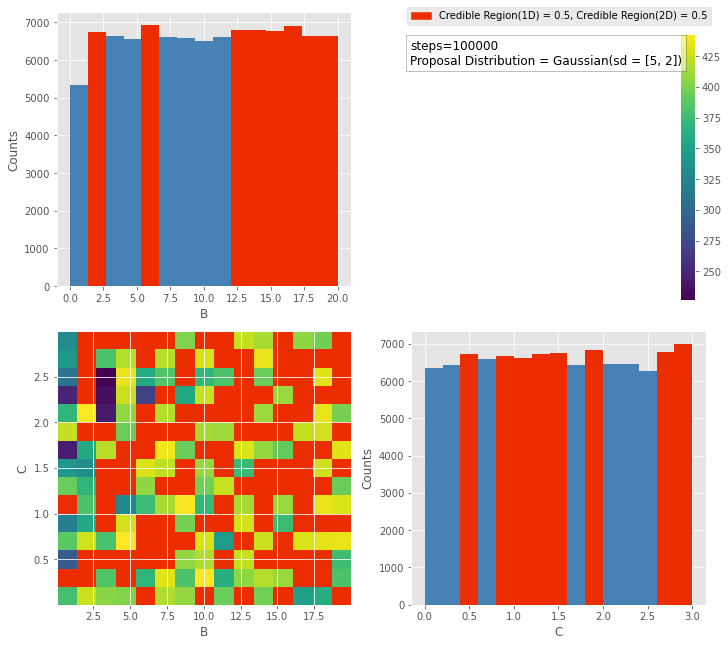

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


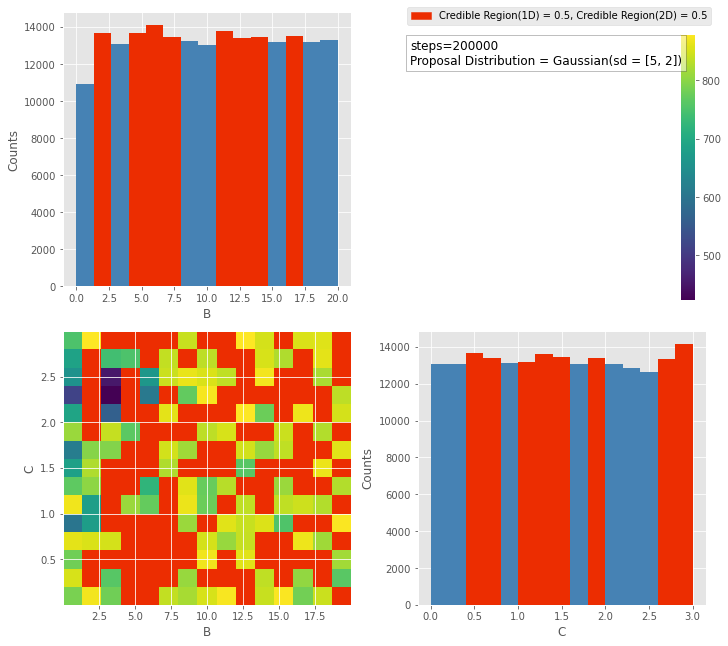

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


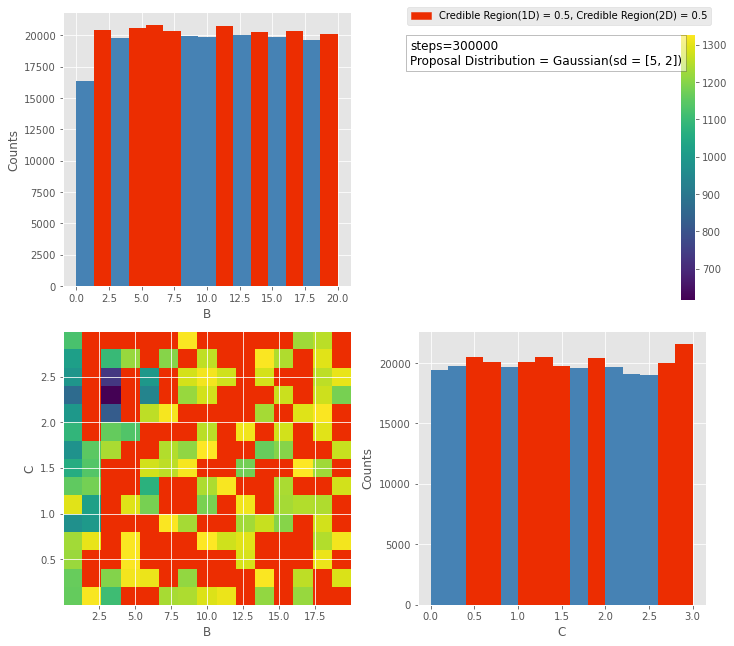

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


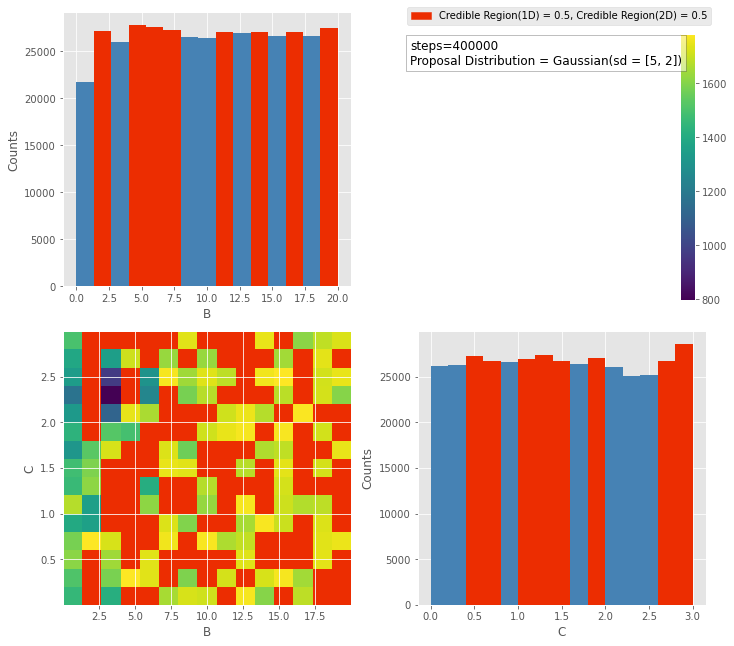

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


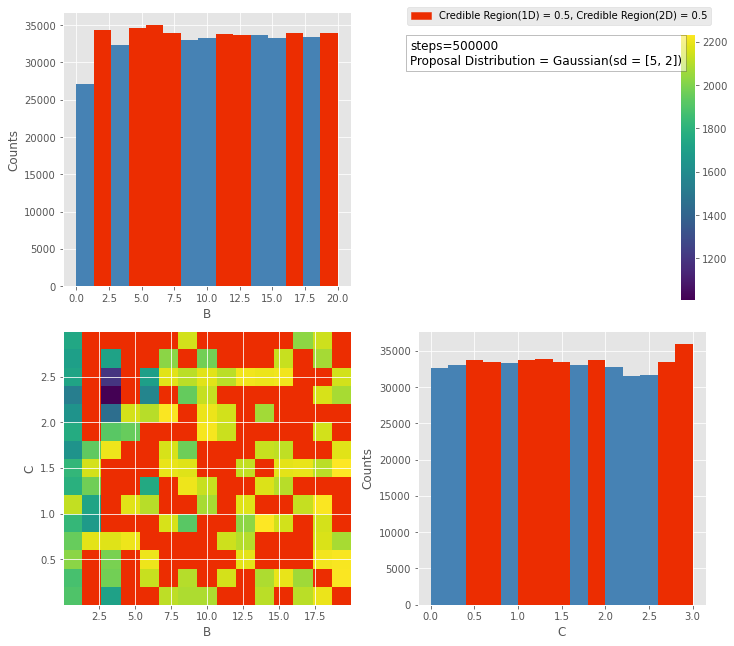

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


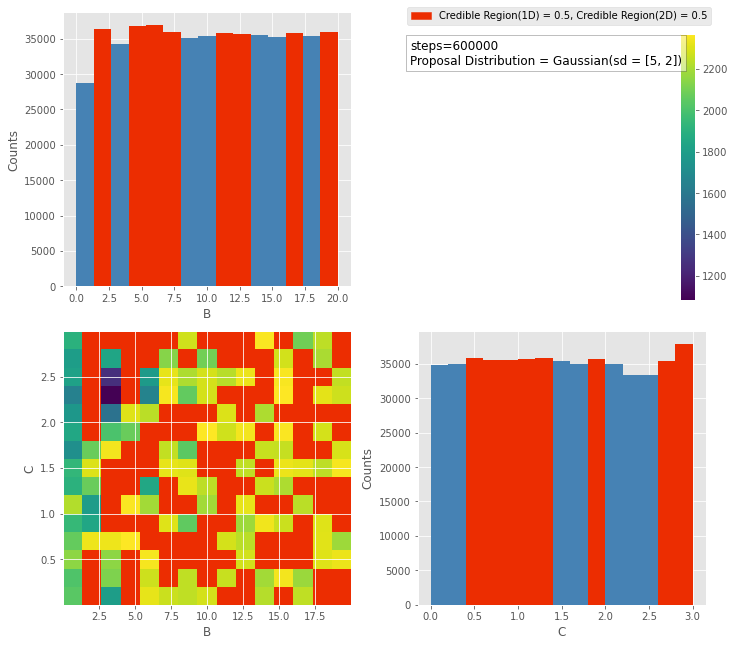

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


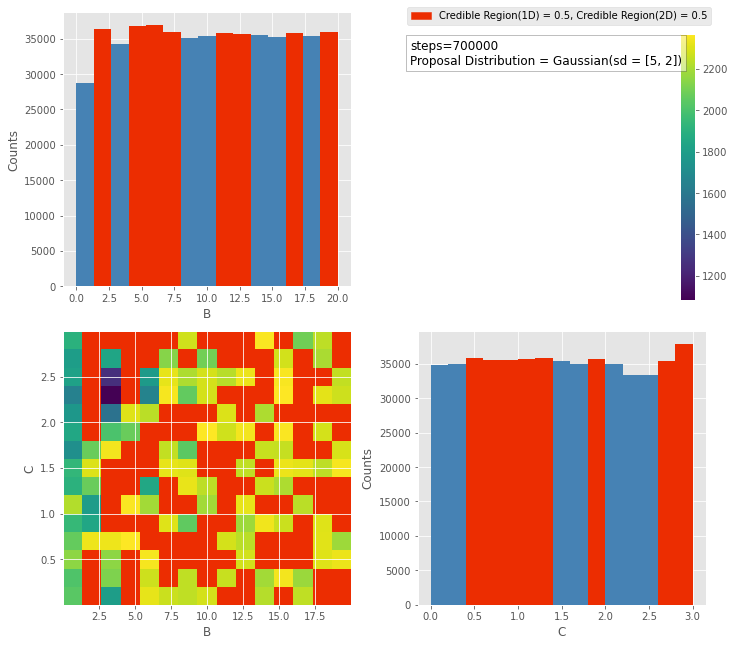

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


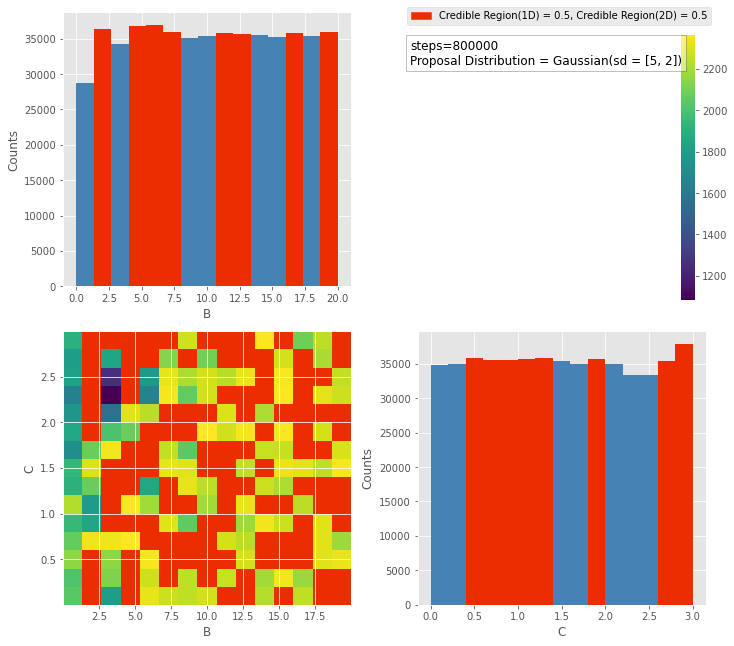

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


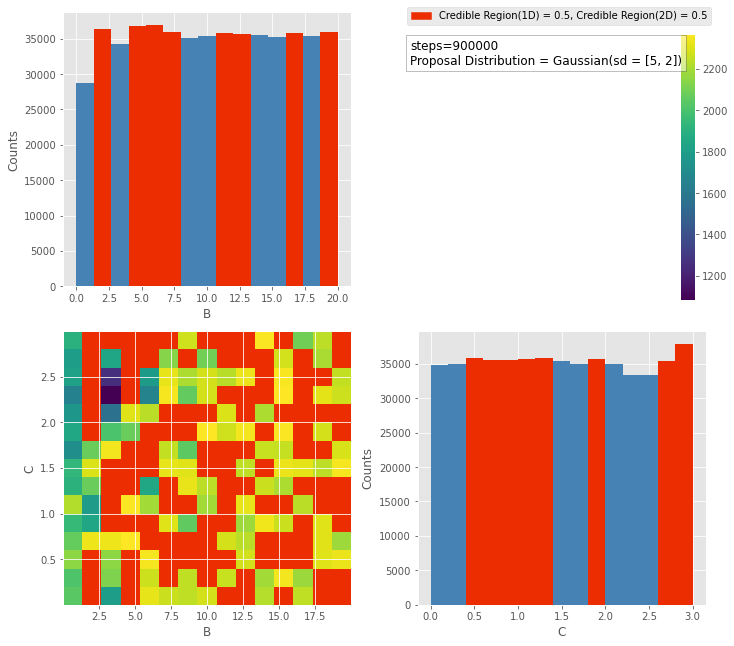

/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:80: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(heatmap, cax=cbar_ax)
/var/folders/sn/xtxyc9q57g94hd9p4mx0nfb80000gn/T/ipykernel_86222/700580651.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


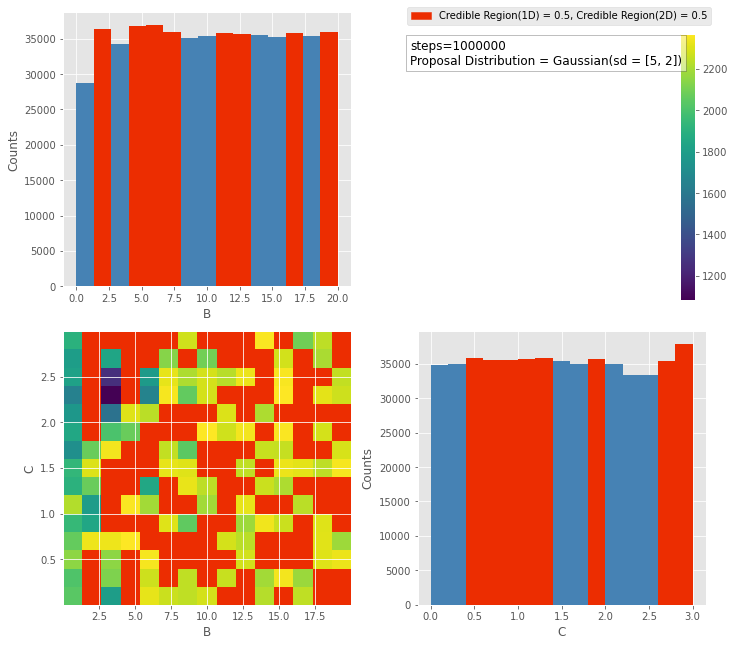

In [71]:
sd = SDs[k]
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    steps = i*100000
    information = f"steps={steps}\nProposal Distribution = Gaussian(sd = {sd})"
    _ = density_plots(
        Res[k]["Thetas"][:steps], 
        bins=15,
        burn_in=1000,
        plot_axis=[0, 1],
        axis_name=["B", "C"],
        cr_1D=0.5,
        cr_2D=0.5,
        information=information
    )

Text(0, 0.5, 'Times')

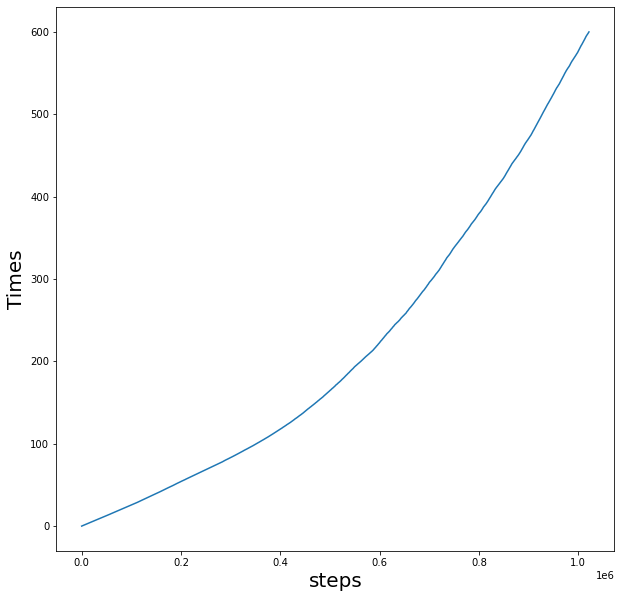

In [67]:
k = 1
Ts = [(i+1)*200 for i in range(len(Res[k]["Run_Times"]))]
plt.plot(Ts, Res[k]["Run_Times"])
plt.xlabel("steps", fontsize=20)
plt.ylabel("Times", fontsize=20)

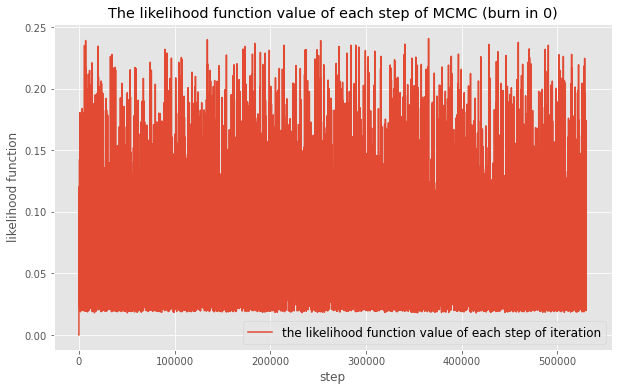

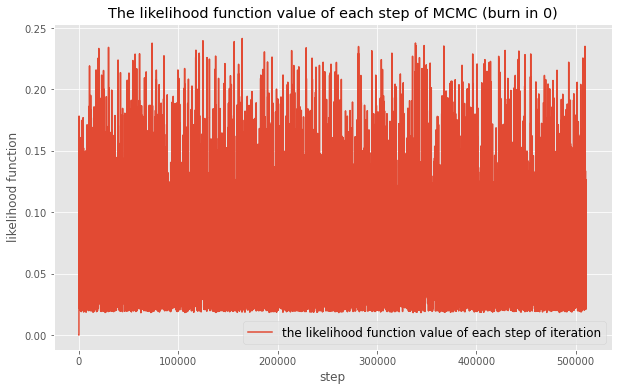

In [55]:
for Res_G_SF, sd in zip(Res, SDs):
    Vts.targetDis_step_plot(Thetas=Res_G_SF["Thetas"], rho=SF_l.Posterior, target_type="likelihood function", burn_in=0, figsize=(10,6))

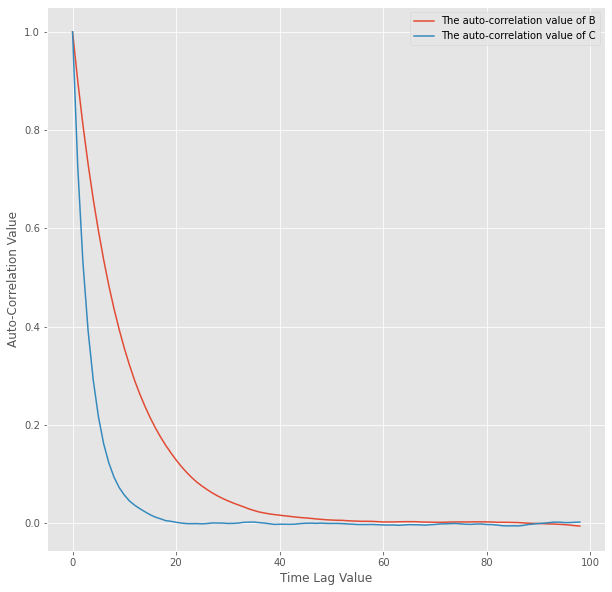

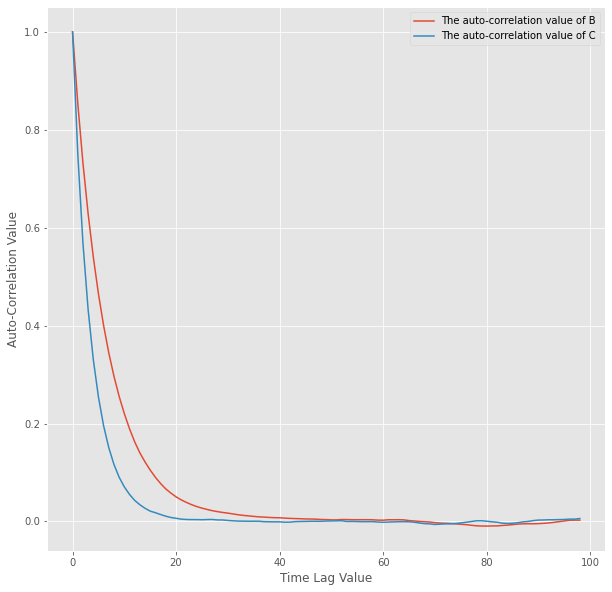

In [56]:
for Res_G_SF, sd in zip(Res, SDs):
    Vts.auto_corr_plot(Res_G_SF["Thetas"], [0,1], ["B", "C"], 100, [1000, steps])

### Testing Functions

In [8]:
Vts.UpdatingPlot(Data_range=[0, 200], Data=Res[0]["Thetas"])

### Hamiltonian MCMC

In [12]:
steps = 20000
Prop_H = PDs.HamiltonianProposalFunction(rho=SF_l.Posterior, epsilon=0.1, L=4)
MHMC_SF = MHMC(rho=Prop_H.U, log_likelihood=True)
Res_H_SF = MHMC_SF.generate(
    theta0=[1 for _ in range(2)], 
    qProb=Prop_H.log_qProb,
    qSamp=Prop_H.qSample,
    steps=steps,
    OutputRunTime=100,
    MaxTime=600
)

/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DZ/MCMC/MetropolisHastingMCMC/ProposalDistributions.py:229: RuntimeWarning: divide by zero encountered in log
  return np.log(self.rho(theta))
/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DZ/BayesianInference/Likelihood_functions/Sinewave.py:61: RuntimeWarning: invalid value encountered in sin
  Res[in_range] = (self.A * np.sin(self.B * (np.sqrt(X[in_range, 0] ** 2 + X[in_range, 1] ** 2) - self.C)) + self.A)


In [14]:
print(Res_H_SF["Run_Times"][-1])

57.278778026


In [15]:
Vts.density_plot(
    Res_H_SF["Thetas"], 
    bins=30,
    burn_in=100,
    credible_region=0,
    x_name="B",
    y_name="C",
    alpha=1
)

ValueError: autodetected range of [nan, nan] is not finite

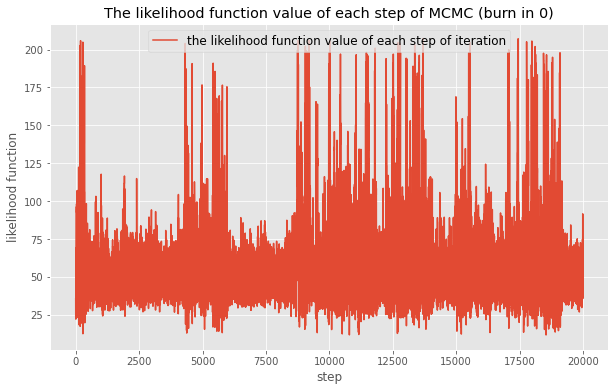

In [37]:
Vts.targetDis_step_plot(Thetas=Res_H_SF["Thetas"], rho=SF_l.Posterior, target_type="likelihood function", burn_in=0, figsize=(10,6))

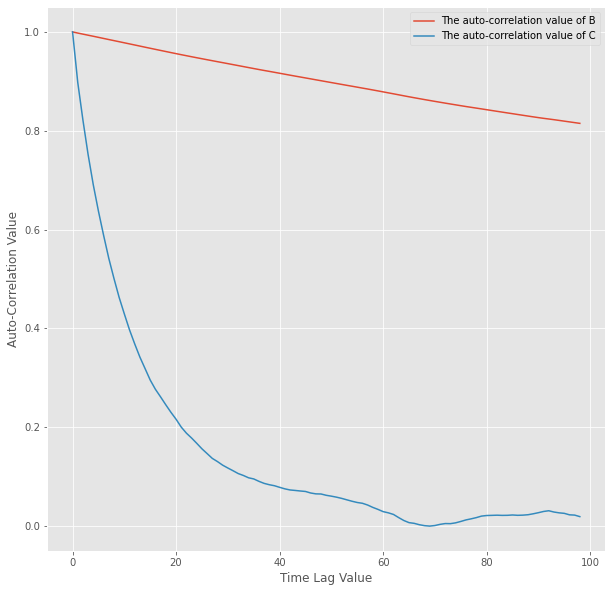

In [38]:
Vts.auto_corr_plot(Res_H_SF["Thetas"], [0,1], ["B", "C"], 100, [1000, 60000])

In [46]:
UpdatingPlot(Data_range=[0, 200], Data=Res_H_SF["Thetas"])

# Dfference Function

In [18]:
def density_ratioplot(Thetas, rho, bins, x_axis=0, y_axis=1, x_name="x", y_name="y", burn_in=0, alpha=1, label="", Save_fig=False, fig_name="density plot", Plot3D=False):
    """
    Plot an interactive 3D heatmap of a pair of dimensions from the input data.

    Arguments:
    Thetas (np.array): the value of parameters generated by the MCMC model
    bins (int): the number of bins of each histogram and heat map
    x_axis (int): the index of the x-axis to plot
    y_axis (int): the index of the y-axis to plot
    x_name (string): the name of the x-axis to plot
    y_name (string): the name of the y-axis to plot
    burn_in (int): the number of the data points want to "burn_in" for the graph
    credible_region (float): the size of the credible region in percent
    figsize (tuple): the size of the figure
    label (string): the label want to add to the plot
    Save_fig (bool): decide whether to save the output figure of the function
    fig_name (string): the saved figure name

    Returns:
    None
    """
    Thetas = np.asarray(Thetas)

    # prepare the data for the 2D histogram
    hist, xedges, yedges = np.histogram2d(Thetas[burn_in:, x_axis], Thetas[burn_in:, y_axis], bins=bins)
    xmid = 0.5*(xedges[1:] + xedges[:-1])
    ymid = 0.5*(yedges[1:] + yedges[:-1])
    X, Y = np.meshgrid(xmid, ymid)

    Likeli = np.asarray([rho(np.asarray([x,y])) for (x,y) in zip(X.flatten(), Y.flatten())])
    Likeli = Likeli.reshape(X.shape)
    Likeli = (Likeli)
    hist = (hist.T) / Thetas.shape[0]
    # Calculate the Z axis value of the heat map
    Z = ((Likeli)/(hist))
    Z[hist==0] = 0
    Z = 2*(Z-np.min(Z))/np.max(Z-np.min(Z))

    if Plot3D:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        # plot the density
        # plot the density plot of the inputted data
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=alpha)
        # # Add contour plots
        # cset = ax.contour(X, Y, hist.T, zdir='z', offset=np.min(hist), cmap=plt.cm.coolwarm)
        # cset = ax.contour(X, Y, hist.T, zdir='x', offset=np.min(xedges), cmap=plt.cm.coolwarm)
        # cset = ax.contour(X, Y, hist.T, zdir='y', offset=np.max(yedges), cmap=plt.cm.coolwarm)

        fig.colorbar(ax.plot_surface(X, Y, Z, cmap='viridis'))
        # create 3D heatmap with the data prepared above
        ax.set_title(f"3D ratio plot of true value and approximation of {x_name} and {y_name}"+label)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel("ratio")
        ax.set_box_aspect([1, 1, 0.7])
        # ax.view_init(elev=-1.7, azim=-1.7)
        ax.dist = 10

        plt.tight_layout()
        if (Save_fig): 
            plt.savefig(fig_name+".png")
        plt.show()
    else:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        # plot the density plot of the inputted data
        ax.imshow(Z, cmap='viridis', origin='lower', alpha=alpha, extent=[X.min(), X.max(), Y.min(), Y.max()], aspect='auto')

        fig.colorbar(ax.imshow(Z, cmap='viridis', origin='lower', alpha=alpha, extent=[X.min(), X.max(), Y.min(), Y.max()], aspect='auto'))
        # create 3D heatmap with the data prepared above
        ax.set_title(f"2D ratio plot of true value and approximation of {x_name} and {y_name}"+label)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.dist = 10

        plt.tight_layout()
        if (Save_fig): 
            plt.savefig(fig_name+".png")
        plt.show()

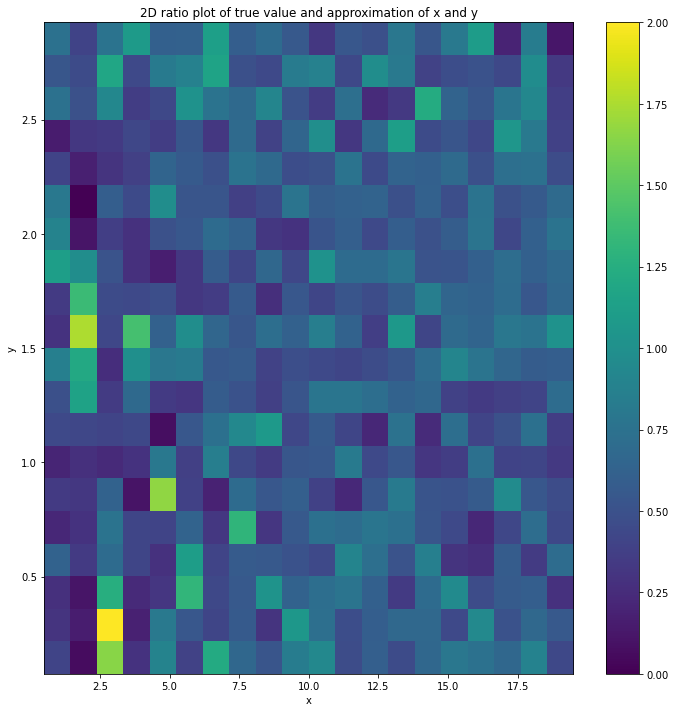

In [19]:
i = 2
density_ratioplot(
    Thetas=Res[i]["Thetas"][:70000],
    rho=SF_l.Posterior,
    bins=20
)